In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

def loadfile(k, r, op, it, e):
  generationScores = []
  bests = []
  bestVecs = []

  with open('results/stats-v1-PSO-%dp-r%d-5u-5.00km-op_%s-%dit-e%d.txt' % (k, r, op, it, e), 'r') as f:
    for i in range(it):
      line = f.readline()
      if not line or line == '':
        print('FIN')
        break

      words = line.split(':')

      if 'final' in words[0]:
        print('THE END', words)
        break

      magic, nSamples, best = words



      scores = [float(v) for v in f.readline().split(',')]
      generationScores.append(scores)
      bests.append(float(best))

      for idxSample in range(int(nSamples)):
        score = float(f.readline())
        vec = f.readline()
        # Whatever
        if idxSample == 0: bestVecs.append(vec)

  return generationScores, bests, bestVecs

In [2]:
gen, best, vecs = loadfile(128, 0, 'nm', 1000, 0)
gen[-1]

THE END ['PNMfinal', '1927', '23.05740557361569\n']


[-92348.5145,
 21.0051,
 21.0153,
 21.0164,
 21.0448,
 23.0431,
 23.0464,
 23.0483,
 23.0485,
 23.0494,
 23.05,
 23.0502,
 23.0506,
 23.0507,
 23.0519,
 23.0519,
 23.0522,
 23.0523,
 23.0525,
 23.0527,
 23.0529,
 23.0529,
 23.053,
 23.0531,
 23.0531,
 23.0535,
 23.0536,
 23.0537,
 23.0537,
 23.0538,
 23.054,
 23.0541,
 23.0543,
 23.0543,
 23.0543,
 23.0543,
 23.0543,
 23.0543,
 23.0544,
 23.0545,
 23.0545,
 23.0545,
 23.0546,
 23.0547,
 23.0547,
 23.0548,
 23.0548,
 23.0548,
 23.0549,
 23.0549,
 23.0549,
 23.055,
 23.0551,
 23.0552,
 23.0552,
 23.0552,
 23.0552,
 23.0552,
 23.0553,
 23.0553,
 23.0554,
 23.0554,
 23.0555,
 23.0555,
 23.0555,
 23.0555,
 23.0556,
 23.0556,
 23.0556,
 23.0556,
 23.0556,
 23.0556,
 23.0556,
 23.0557,
 23.0557,
 23.0557,
 23.0557,
 23.0558,
 23.0558,
 23.0558,
 23.0559,
 23.0559,
 23.0559,
 23.0559,
 23.0559,
 23.0559,
 23.056,
 23.056,
 23.056,
 23.056,
 23.056,
 23.056,
 23.056,
 23.0561,
 23.0561,
 23.0561,
 23.0561,
 23.0561,
 23.0561,
 23.0561,
 23.0562

THE END ['PNMfinal', '1927', '22.23971342621613\n']


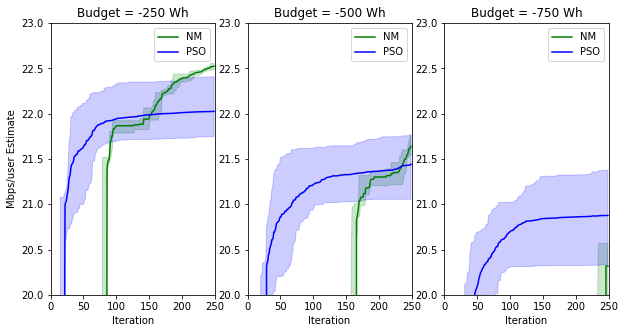

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))


# What we have:
# 1000its of both for 0 and -500
# 250 its of both for -250, -500, -750 (except r0 for -500 we have the 1000 :/ )

curves = {}

e = -250
for idx, e in [(0, -250), (1, -500), (2, -750)]:
  ax[idx].set_ylim(20, 23)
  
  for col, opt in [('green', 'nm'), ('blue', 'pso')]:
    stacked = []
    for i in range(5):
      # Reach into the 1000it for -500 r0
      q = 1000 if i == 0 and e == -500 else 250
      gen, best, vecs = loadfile(128, i, opt, q, e)
      stacked.append(best[:250])
    stacked = np.array(stacked)

    #mstd = stacked.std(axis=0)
    ma = stacked.mean(axis=0)
    #ax.fill_between(range(len(ma)), ma - 2 * mstd, ma + 2 * mstd, alpha=0.2)
    ax[idx].fill_between(range(len(ma)), stacked.min(axis=0), stacked.max(axis=0), alpha=0.2, color=col)
    curves[opt] = ax[idx].plot(ma, color=col)[0]
  ax[idx].legend([curves['nm'], curves['pso']], ['NM', 'PSO'])
  ax[idx].set_xlabel('Iteration')
  ax[idx].set_xlim(0, 250)
  ax[idx].set_title('Budget = %d Wh' % e)
    
ax[0].set_ylabel('Mbps/user Estimate')
fig.savefig('optimize-performance.pdf', bbof_inches='tight')

THE END ['PNMfinal', '1927', '23.05740557361569\n']
THE END ['PNMfinal', '1927', '22.23971342621613\n']


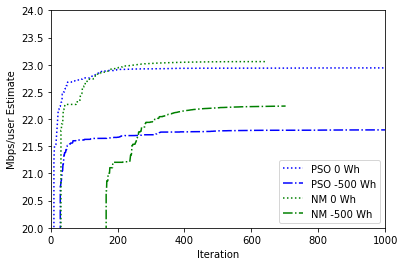

In [4]:
fig, ax = plt.subplots()

def plotCurve(ax, op, e, **kwargs):
  gen, best, vecs = loadfile(128, 0, op, 1000, e)
  ax.plot(best, **kwargs)

ax.set_ylim(20, 24)
ax.set_xlim(0, 1000)
ax.set_xlabel('Iteration')
ax.set_ylabel('Mbps/user Estimate')

plotCurve(ax, 'pso', 0, color='blue', linestyle=':')
plotCurve(ax, 'pso', -500, color='blue', linestyle='-.')
plotCurve(ax, 'nm', 0, color='green', linestyle=':')
plotCurve(ax, 'nm', -500, color='green', linestyle='-.')

ax.legend(['PSO 0 Wh', 'PSO -500 Wh', 'NM 0 Wh', 'NM -500 Wh'])
#fig.savefig('longrun-perf.pdf', bbox_inches='tight')

In [5]:
from thesis.ThesisCraft import craft
from thesis.optimize.functions import (
  SplineyFitnessHelper, Defunc
)
from thesis.EvalHelper import Judge
from thesis.Scenario import Scenario
from tqdm.auto import tqdm
from thesis.Flight import Flight

import random
random.seed(0)
np.random.seed(random.randint(0,99999999))

scene = Scenario()
scene.addRandomGroundUsersUniformCircular(5, r = 5 * 1000)
judge = Judge(scene, craft)

times = pd.date_range(start = '2020-11-29T08', end = '2020-11-30T08', freq='10S', tz='America/Detroit').to_series()


helper = SplineyFitnessHelper(
  judge, craft, times,
  expr = [
    # Unimportant here
    Defunc(1)
  ],
  # Scale trajectory to evenly fit into a 24-hour window
  desiredDuration = 24*3600,
  # Use our z-scheduling model
  # NB this performs MUCH better than letting the optimizer pick every Z coordinate, or every Z delta
  #    we think this is mostly because these require multi-dimensional coordination, or have global impacts (respectively)
  #    TODO fix this up so the optimizer can pick Z offsets, to do clever local things like angling more towards the sun
  zMode = 'schedule'
)

# From NS3 defaults
radioParams = {
  'xmitPower': 30, # dBm
  'B': 180e3 * 25, # 25 180kHz RBs = 4.5 MHz
  'N0': -174       # See lte-spectrum-value-helper.cc kT_dBm_Hz
}

Mass is 85.85 kg (50.16 kg struct, 15.50 kg bat)


In [18]:
def readVec(fp):
  pathToVec = 'optimized-flights/%s.txt' % fp
  
  f = open(pathToVec, 'r')
  vec = f.read()
  f.close()
  return list(map(float, ''.join(vec.split('\n')).split(',')))

def readTraj(fp):
  vec = readVec(fp)
  
  vecToTraj = helper.getTrajBuilder()
  return vecToTraj(vec)

def readAndGenStats(fp):
  traj, alphas = readTraj(fp)

  flight=Flight(craft, traj, alphas, **radioParams)
  stats = judge.flightStats(flight, times)
  df = pd.DataFrame(stats['throughput'], index=times)
  df=df.groupby(pd.Grouper(freq='30min')).mean()
  return df

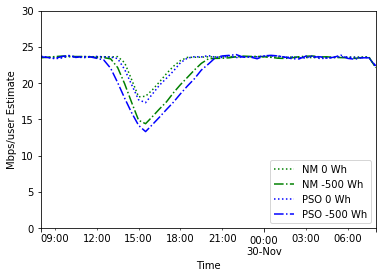

In [7]:
def plot(f, ax, **kwargs):
  df = readAndGenStats(f)
  #ax.plot((df / 1e6).mean(axis=1), **kwargs)
  (df / 1e6).mean(axis=1).plot(ax=ax, **kwargs)

import matplotlib.ticker as mtick
  
fig, ax = plt.subplots()
ax.set_ylim(0, 30)

plot('nm-0Wh-r0', ax, color='green', linestyle=':')
plot('nm-500Wh-r0', ax, color='green', linestyle='-.')
plot('pso-0Wh-r0', ax, color='blue', linestyle=':')
plot('pso-500Wh-r0', ax, color='blue', linestyle='-.')

ax.set_ylabel('Mbps/user Estimate')
ax.set_xlabel('Time')
#ax.set_xlim(times[0], times[-1])
#ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.legend(['NM 0 Wh', 'NM -500 Wh', 'PSO 0 Wh', 'PSO -500 Wh'], loc='lower right')

fig.savefig('longrun-estimate.pdf', bbox_inches='tight')

KeyError: 0

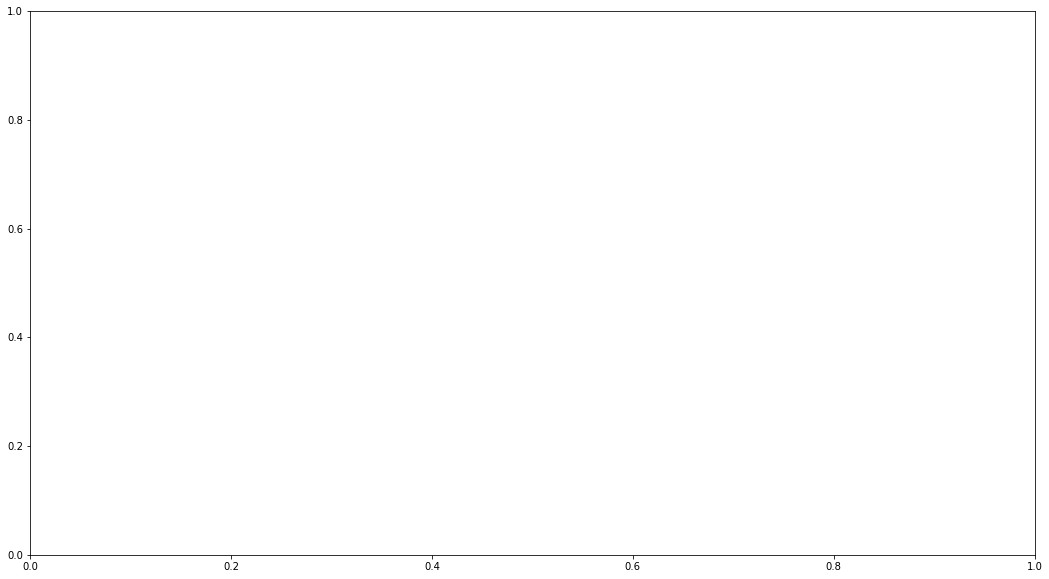

In [8]:
def mkPathPacked(name, trajectory, run, users, radius, ul, dl):
    return './packed2/%s_%s_run%d_usr%d_rad%.2f_ul%d_dl%d.parquet.gzip' % (name, trajectory, run, users, radius, ul, dl)

def loadAll(traj, runs, usr=5, rad=5, ul=False, dl=True, freq = '30min'):
    def load(run):
        srv = pd.read_parquet(mkPathPacked('serverStats', traj, run, usr, rad, ul, dl), engine='fastparquet')
        cln = pd.read_parquet(mkPathPacked('clientStats', traj, run, usr, rad, ul, dl), engine='fastparquet')

        # Number of bytes received / number of bytes sent, grouped/smoothed into 10 minute buckets, averaged over each user
        return (srv / cln).groupby([pd.Grouper(freq=freq, level='time'), 'flowId']).mean().mean(level='time')


    frame = load(runs[0])
    for i in runs[1:]:
        frame = frame.merge(load(i), on='time', suffixes=['_%d' % (i - 1), '_%d' % i])
        
    return frame

def loadSend(traj, runs, usr=5, rad=5, ul=False, dl=True, freq = '30min'):
    def load(run):
        srv = pd.read_parquet(mkPathPacked('serverStats', traj, run, usr, rad, ul, dl), engine='fastparquet')
        cln = pd.read_parquet(mkPathPacked('clientStats', traj, run, usr, rad, ul, dl), engine='fastparquet')

        # Number of bytes received / number of bytes sent, grouped/smoothed into 10 minute buckets, averaged over each user
        return cln.groupby([pd.Grouper(freq=freq, level='time'), 'flowId']).sum().sum(level='time')


    frame = load(runs[0])
    for i in runs[1:]:
        frame = frame.merge(load(i), on='time', suffixes=['_%d' % (i - 1), '_%d' % i])
        
    # Divide into per-second values
    frame /= pd.to_timedelta(freq).total_seconds()
        
    return frame

def loadReceive(traj, runs, usr=5, rad=5, ul=False, dl=True, freq = '30min'):
    def load(run):
        srv = pd.read_parquet(mkPathPacked('serverStats', traj, run, usr, rad, ul, dl), engine='fastparquet')
        cln = pd.read_parquet(mkPathPacked('clientStats', traj, run, usr, rad, ul, dl), engine='fastparquet')

        # Number of bytes received / number of bytes sent, grouped/smoothed into 10 minute buckets, averaged over each user
        return srv.groupby([pd.Grouper(freq=freq, level='time'), 'flowId']).sum().sum(level='time')


    frame = load(runs[0])
    for i in runs[1:]:
        frame = frame.merge(load(i), on='time', suffixes=['_%d' % (i - 1), '_%d' % i])
        
    # Divide into per-second values
    frame /= pd.to_timedelta(freq).total_seconds()
        
    return frame
  

fig, ax = plt.subplots(figsize=(18, 10))
  
for f in ['nm-0Wh-r0', 'nm-500Wh-r0', 'pso-0Wh-r0', 'pso-500Wh-r0']:
#for f in ['pso-500Wh-r0']:
  df = loadReceive(f, range(5))
  df.index += times[0]
  df *= 8e-6
  df = df.mean(axis=1)


  ax.plot(df, color='red')


  df2 = readAndGenStats(f).mean(axis=1) / 1e6
  ax.plot(df2*0.77, color='blue')

  ax.set_xlim(times[0], times[-1] - pd.to_timedelta('30min'))
  ax.set_ylim(0, 26)

  
  print(f, (df / df2).min(), (df / df2).max())
  
  # ax2 = ax.twinx()
  # ax2.set_ylim(0, 1)
  # ax2.plot(df / df2)
  

In [14]:
traj, alphas = readTraj('nm-500Wh-r0')
traj.render()

Graphics3d Object

In [46]:
from math import pi
numPoints = 4 * 24

template = [3000, 0.1, 0.5, 0.5, 0.5, 0.5] + [
    0.4, 1800.1, 0, 5, 5,
    1800.3, 0.2, 3*pi/2, 5, 5,
    0.2, -1800.3, pi, 5, 5,
    -1800.1, 0.4, pi / 2, 5, 5,
] * numPoints

vec = readVec('nm-500Wh-r0')
diff = [vec[i] - template[i] for i in range(len(vec))]
print('gain %.2f, rest %.2f, ascend %.2f, sustain %.2f, descend %.2f, rest %.2f' % tuple(diff[0:6]))

# X Y Heading a1 a2
ndiff = np.array(diff[6:])
ntemp = np.array([1800, 1800, pi, 5, 5] * 4 * numPoints)
rat = ndiff / ntemp - 1
pd.DataFrame(abs(ndiff).reshape(1920/5,5)).describe()

gain 3510.50, rest 0.48, ascend -0.24, sustain -0.48, descend 0.11, rest 0.76


,0,1,2,3,4
count,384.000000,384.000000,384.000000,384.000000,384.000000
mean,23.080756,23.499854,0.023974,0.220554,0.231183
std,17.329599,17.890553,0.017958,0.169143,0.158624
min,0.043700,0.103300,0.000011,0.000200,0.000200
25%,9.257425,9.433250,0.009698,0.094050,0.104075
50%,19.294350,19.913000,0.021206,0.185500,0.208550
75%,33.821575,33.953700,0.033402,0.309225,0.337275
max,91.155800,93.897400,0.083100,1.002700,0.771200


In [88]:
from thesis.optimize.functions import (
  SplineyFitnessHelper, batteryReward, throughputReward, throughputPenalty,
  energyPenalty, gravityReward, radiusPenalty, altitudePenalty, energyPenalty,
  speedPenalty, alphaPenalty, thrustPenalty
)

times = pd.date_range(start = '2020-11-28T09', end = '2020-11-29T09', freq='10S', tz='America/Detroit').to_series()

helper = SplineyFitnessHelper(
  judge, craft, times,
  expr = [
    # === Optimize this ===
    # Throughput, in Mbps/user
    throughputReward() / 1e6L / len(scene.users),

    # === Subject to these constraints (as penalty functions) ===
    # Flight volume constraints
    radiusPenalty(2000) * 1e-6L,
    altitudePenalty(1000, 10000),
    # We have seen the best results with a 1.0 gravityCoeff, interestingly enough
    # But we should try tweaking this again later
    energyPenalty(-500, gravityCoeff = 0.0),
    # Some aircraft/modelling constraints
    # (importantly keeps the optimizer from discovering "rocket mode", which we don't model correctly)
    thrustPenalty(hi = 100),
    speedPenalty(lo = 6, hi = 25)
  ],
  # Scale trajectory to evenly fit into a 24-hour window
  desiredDuration = 24*3600,
  # Use our z-scheduling model
  # NB this performs MUCH better than letting the optimizer pick every Z coordinate, or every Z delta
  #    we think this is mostly because these require multi-dimensional coordination, or have global impacts (respectively)
  #    TODO fix this up so the optimizer can pick Z offsets, to do clever local things like angling more towards the sun
  zMode = 'schedule'
)

for f in ['pso-0Wh-r0', 'pso-500Wh-r0', 'nm-0Wh-r0', 'nm-500Wh-r0']:
  print('\n', f)
  vec = readVec(f)
  # Compare to an ablated vector which is just the template for everything but schedule
  mvec = vec.copy()
  mvec[6:] = template[6:]

  fitness = helper.getFitness(debug=True, initial_charge=0.5)
  vec2traj = helper.getTrajBuilder()

  print(fitness(vec))
  print(fitness(mvec))


  traj, alphas = vec2traj(vec)
  mtraj, malphas = vec2traj(mvec)

  stats = judge.flightStats(Flight(craft, traj, alphas), times)
  mstats = judge.flightStats(Flight(craft, mtraj, malphas), times)

  from thesis.optimize.functions import calcBatteryChange
  print('Energy gained (Final energy - Initial Energy):')
  print('  optimized: %.2f Wh' % calcBatteryChange(stats))
  print('  ablated:   %.2f Wh' % calcBatteryChange(mstats))


 pso-0Wh-r0
(((((((TR<114670272.36763707>/1000000.0)/5)+(RP<-0.0>*1e-06))+AP<-0.0>)+EP<-250028.9249000671>)+TRP<-0.0>)+VP<-0.0>)
(((((((TR<114595434.04988432>/1000000.0)/5)+(RP<-0.0>*1e-06))+AP<-0.0>)+EP<-174765.0036014024>)+TRP<-0.0>)+VP<-0.0>)
Energy gained (Final energy - Initial Energy):
  optimized: -0.03 Wh
  ablated:   81.95 Wh

 pso-500Wh-r0
(((((((TR<109266314.34864466>/1000000.0)/5)+(RP<-0.0>*1e-06))+AP<-0.0>)+EP<0>)+TRP<-0.0>)+VP<-0.0>)
(((((((TR<109267007.57998198>/1000000.0)/5)+(RP<-0.0>*1e-06))+AP<-0.0>)+EP<0>)+TRP<-0.0>)+VP<-0.0>)
Energy gained (Final energy - Initial Energy):
  optimized: 500.95 Wh
  ablated:   644.30 Wh

 nm-0Wh-r0
(((((((TR<115289152.88302898>/1000000.0)/5)+(RP<-0.0>*1e-06))+AP<-0.0>)+EP<-249191.86401900597>)+TRP<-0.0>)+VP<-0.0>)
(((((((TR<115269923.9289707>/1000000.0)/5)+(RP<-0.0>*1e-06))+AP<-0.0>)+EP<-254084.70669536846>)+TRP<-0.0>)+VP<-0.0>)
Energy gained (Final energy - Initial Energy):
  optimized: 0.81 Wh
  ablated:   -4.07 Wh

 nm-500Wh-r0
(((